In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import json

/home/rseetharaman_umass_edu/.conda/envs/rome/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [61]:
import numpy as np

In [2]:
def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]

In [9]:
def find_all(a_str, sub):
    start = 0
    ans = []
    while True:
        start = a_str.find(sub, start)
        if start == -1: return ans
        ans.append(start)
        start += len(sub) # use start += 1 to find overlapping matches

def find_token_range(tokenizer, prompt, substring):
    token_array = tokenizer(prompt)['input_ids']
    toks = decode_tokens(tokenizer, token_array)
    # print(toks)
    whole_string = "".join(toks)
    char_locs = find_all(whole_string, substring)
    loc = 0
    cur=0
    tok_start, tok_end = None, None
    possibles = []
    for i, t in enumerate(toks):
        loc += len(t)
        if cur >= len(char_locs):
            break
        if tok_start is None and loc > char_locs[cur]:
            tok_start = i
        if tok_end is None and loc >= char_locs[cur] + len(substring):
            tok_end = i + 1
            possibles.append([tok_start, tok_end])
            tok_start, tok_end = None, None
            cur+=1
    return possibles

In [10]:
def attn_contrib(model, tokenizer, prompt, subject, attribute, num_layers=32, device=torch.device("cuda"), maxlength=250):
    norms = []
    ids = tokenizer(prompt, return_tensors='pt').to(device)
    sequence_output = model.generate(**ids, max_length=maxlength)
    subject_position = find_token_range(tokenizer, prompt, ''.join(subject.split()))[-1]
    attr_position = find_token_range(tokenizer, prompt, ''.join(attribute.split()))[-1]
    attn = sequence_output.attentions
    for i in range(num_layers):
        attn_at_layer = attn[0][i][0]
        norm = torch.max(attn_at_layer[:, subject_position, attr_position]).item()
        norms.append(norm)
    return norms

In [11]:
device = torch.device("cuda")

In [12]:
rag_context = '''
MacApp is the object oriented application framework for Apple Computer's discontinued classic Mac OS. Released in 1985, it transitioned from Object Pascal to C++ in 1991's version 3.0 release, which offered support for much of System 7's new functionality. MacApp was used for a variety of major applications, including Adobe Photoshop and SoftPress Freeway. Microsoft's MFC and Borland's OWL were both based directly on MacApp concepts.\nOver a period of ten years, the product had periods where it had little development followed by spurts of activity. Through this period, Symantec's Think Class Library/Think Pascal had become a serious competitor to MacApp, offering a simpler model in a much higher-performance integrated development environment (IDE).
'''

In [13]:
text = f'''Answer the question solely based on the given context
Context: {rag_context}
Question: MacApp is a product of
'''
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

In [14]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", output_attentions=True, return_dict_in_generate=True,
                cache_dir="/work/pi_dhruveshpate_umass_edu/rseetharaman_umass_edu/.cache/").to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [83]:
knowns = json.load(open("rag_set_0.json"))

In [84]:
instruction = "You are given some context. Answer it solely based on the given context."

In [85]:
rag_contexts = []
subjects = []
attrs = []
for k in knowns:
    document_context = '\n'.join([entry['content'] for entry in k['documents']])
    question = k['query']
    prompt = f'''{instruction}
Context:
{document_context}
Question:
{question}
'''
    rag_contexts.append(prompt)
    subjects.append(''.join(k['subject'].split()))
    attrs.append(''.join(k['attr'].split()))

In [89]:
len(subjects)

10

In [90]:
len(attrs)

10

In [91]:
len(rag_contexts)

10

In [92]:
peak_layer_positions = []

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 29


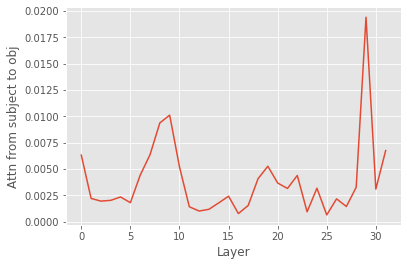

In [93]:
norms = attn_contrib(model, tokenizer, rag_contexts[0], subjects[0], attrs[0], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 10


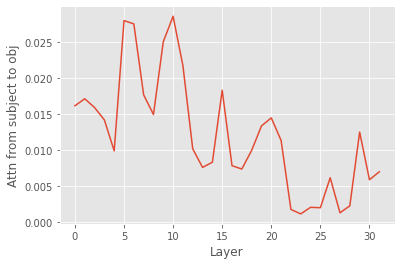

In [94]:
norms = attn_contrib(model, tokenizer, rag_contexts[1], subjects[1], attrs[1], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 0


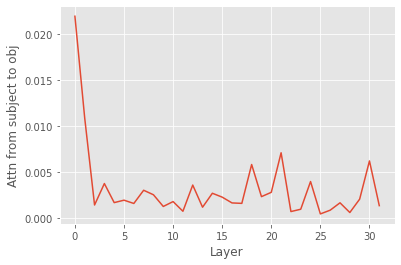

In [95]:
norms = attn_contrib(model, tokenizer, rag_contexts[2], subjects[2], attrs[2], maxlength=1024)
peak = np.argmax(norms)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 21


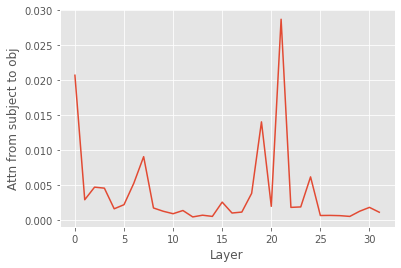

In [96]:
norms = attn_contrib(model, tokenizer, rag_contexts[3], subjects[3], attrs[3], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

In [97]:
rag_contexts[4]

'You are given some context. Answer it solely based on the given context.\nContext:\nWayne Mark Rooney (born 24 October 1985) is an English professional football manager and former player who was most recently the manager of Birmingham City. Widely considered one of the best players of his generation, Rooney is the record goalscorer for Manchester United, and was the record goalscorer for the England national team from 2015 to 2023. He has also made more appearances for England than any other outfield player. Rooney spent most of his playing career as a forward, but was also used in various midfield roles.\nRooney joined the Everton youth team at the age of nine and made his professional debut for the club in 2002 at the age of 16.\nRooney joined the Everton youth team at the age of nine and made his professional debut for the club in 2002 at the age of 16. He spent two seasons at the Merseyside club before moving to Manchester United for £25.6 million in the 2004 summer transfer windo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 20


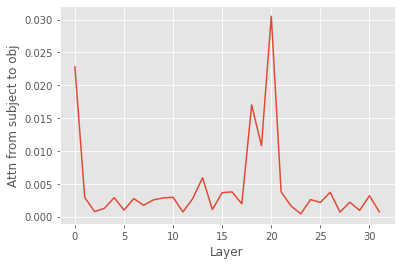

In [98]:
norms = attn_contrib(model, tokenizer, rag_contexts[4], subjects[4], attrs[4], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

In [128]:
print(rag_contexts[4])

You are given some context. Answer it solely based on the given context.
Context:
Wayne Mark Rooney (born 24 October 1985) is an English professional football manager and former player who was most recently the manager of Birmingham City. Widely considered one of the best players of his generation, Rooney is the record goalscorer for Manchester United, and was the record goalscorer for the England national team from 2015 to 2023. He has also made more appearances for England than any other outfield player. Rooney spent most of his playing career as a forward, but was also used in various midfield roles.
Rooney joined the Everton youth team at the age of nine and made his professional debut for the club in 2002 at the age of 16.
Rooney joined the Everton youth team at the age of nine and made his professional debut for the club in 2002 at the age of 16. He spent two seasons at the Merseyside club before moving to Manchester United for £25.6 million in the 2004 summer transfer window, wh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 16


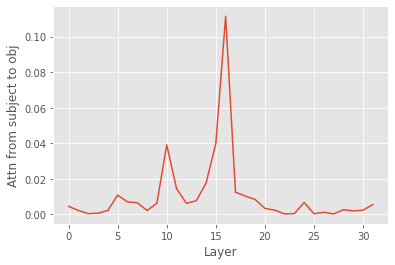

In [99]:
norms = attn_contrib(model, tokenizer, rag_contexts[5], subjects[5], attrs[5], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 19


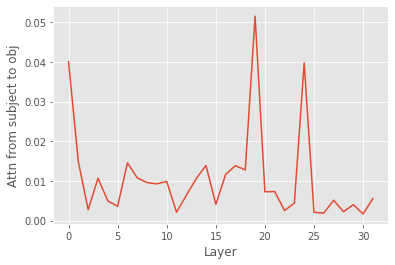

In [100]:
norms = attn_contrib(model, tokenizer, rag_contexts[6], subjects[6], attrs[6], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 1


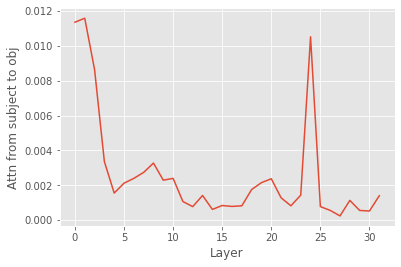

In [101]:
norms = attn_contrib(model, tokenizer, rag_contexts[7], subjects[7], attrs[7], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 22


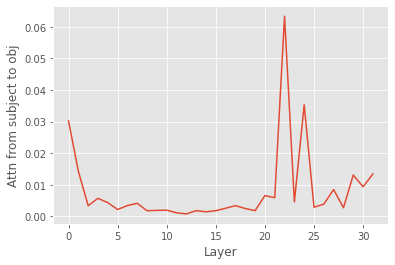

In [102]:
norms = attn_contrib(model, tokenizer, rag_contexts[8], subjects[8], attrs[8], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peak position is 27


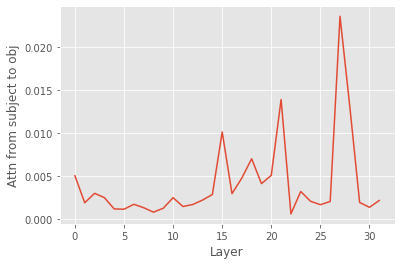

In [103]:
norms = attn_contrib(model, tokenizer, rag_contexts[9], subjects[9], attrs[9], maxlength=1024)
peak = np.argmax(norms)
peak_layer_positions.append(peak)
print(f"Peak position is {peak}")
plt.clf()
plt.xlabel("Layer")
plt.ylabel("Attn from subject to obj")
plt.plot(range(len(norms)), norms)

In [124]:
positions = [prompt.find(at)/len(prompt) for (prompt, at) in zip(rag_contexts, attrs)]

In [120]:
positions

[103, 177, 139, 108, 150, 322, 183, 97, 518, 527]

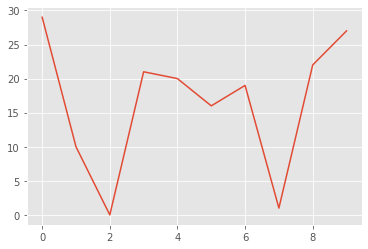

In [125]:
plt.plot(range(10), peak_layer_positions)

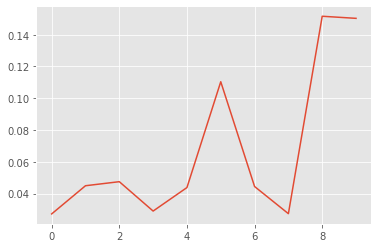

In [126]:
plt.plot(range(10), positions)